
<h1 id="Testing-whether-your-brain-is-a-quantum-computer-(Jupyter)">Testing whether your brain is a quantum computer (Jupyter)<a class="anchor-link" href="#Testing-whether-your-brain-is-a-quantum-computer-(Jupyter)"></a></h1><p><em>Part of the <a href="https://omnisplore.wordpress.com/">omnisplore</a> blog</em>, taken from <a href="https://fiftysevendegreesofrad.github.io/JupyterNotes/brainquantum.html">fiftysevendegreesofrad</a></p>
<p>Quantum supremacy! Quantum perception! Will quantum yoga improve your health? We put a cat in a box... you won't believe what happened next! Rationalists beware, for today we sail dangerously close to the prevailing winds of quantum woo.</p>
<p>Roger Penrose argued that consciousness might arise from quantum gravity. It's going to take me years to understand his book <em>The Road to Reality</em> which for the time being largely goes over my head, so I'm not going to try disputing that particular God-of-the-gaps. But a more concretely testable question is whether or not our brains use quantum effects for computing in any way at all. Sceptics would claim brains are too warm to do anything useful with quantum superposition, but hey, evolution is a powerful system and I wouldn't rule out the possibility that it has found a way.</p>
<p>Kapoor et al wrote a <a href="https://papers.nips.cc/paper/6401-quantum-perceptron-models">paper</a> demonstrating how quantum techniques can improve on the performance of classical perceptrons. For the non expert I should pause to explain what a perceptron is. <a href="https://en.wikipedia.org/wiki/Perceptron">Perceptrons</a> are a machine learning technique developed in the 1950s by people who were trying to imitate the way the brain works. They can be used to classify shapes. We now understand that the brain doesn't work like that, but you can still use perceptrons as a sort of theoretical model of learning in the same way as you can use <a href="https://en.wikipedia.org/wiki/Turing_machine">Turing machines</a> as a theoretical model of computing. If you can prove that quantum weirdness can be exploited to make perceptrons faster, then it can probably make other types of learning faster too.</p>
<p>Kapoor basically did that by proving some time complexity bounds on both quantum and non-quantum perceptrons. Complexity bounds describe how the performance of a computer program changes as you give it more and more data to work on. For example, does loading twice as much data make the program take twice as long? Four times as long? Or does it take the same time either way? If you know the time complexity of the program, you can answer these questions.</p>
<p>All this got me thinking, what if we asked humans to classify shapes into different groups? Then we could make the task more difficult and see how much slower we get at solving it. If the time complexity of human performance <em>behaved like</em> a quantum perceptron, that would be... suggestive, to say the least.</p>
<p>So to test a perceptron, we need to define a space of possible shapes. Let's keep things simple and make it a 2-d space.</p>


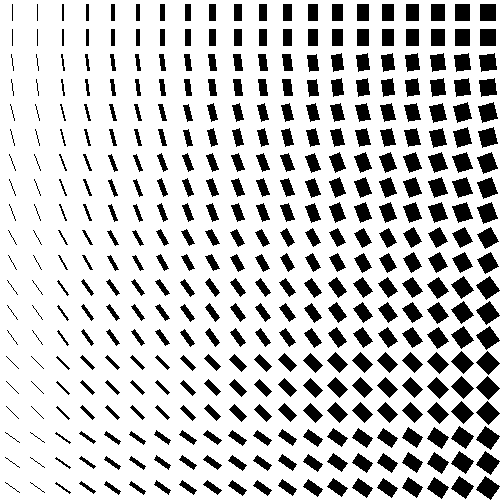

In [1]:

from __future__ import division
from PIL import Image, ImageDraw
import numpy as np
from io import BytesIO
import IPython.display

def showPIL(i):
    '''Helper function to display Python Image Library output in Jupyter'''
    f = BytesIO()
    i.save(f,"bmp")
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

canvas_size = 500
num_cells = 20
cell_size = canvas_size/num_cells

black = (0,0,0)
white = (255,255,255)
red = (255,60,60)
green = (0,220,0)
grey = (220,220,220)

def drawFeature(canvas,x,y,shape,colour):
    '''Draws a feature on canvas in cell position x,y
    Shape is array of [thickness,rotation] both in the range [0,1]'''
    thickness,rotation = shape
    max_line_length = cell_size*2**0.5*0.5*0.95 # slightly under half the cell diagonal
    max_rotation = 60 # degrees. if you rotate all the way to 90 then a square will look the same as when you started
    centerx = (x+0.5)*cell_size
    centery = (y+0.5)*cell_size
    theta = np.radians(rotation*max_rotation)
    dx = max_line_length*np.sin(theta)
    dy = max_line_length*np.cos(theta)
    width = 1+(max_line_length-1)*thickness
    canvas.line((centerx-dx/2,centery-dy/2,centerx+dx/2,centery+dy/2),fill=colour,width=int(width))

def draw_feature_space():
    '''Draws a visualisation of 2-d feature space spanning (0,0) to (1,1)'''
    img = Image.new('RGB', (canvas_size,canvas_size), white)
    draw = ImageDraw.Draw(img)
    for x in range(num_cells):
        for y in range(num_cells):
            shape = np.array([x,y])/num_cells
            drawFeature(draw,x,y,shape,black)
    del draw
    showPIL(img)

draw_feature_space()




<p>Et voila! A selection of shapes to choose from. Actually we have more than the 400 shapes shown here: every point in this 2-d space (thickness x rotation) corresponds to a unique shape.</p>
<p>But we're making a perceptron classification task, so now we need to classify the shapes, in a way a perceptron can understand. Perceptrons partition feature space using hyperplanes. In this case that means, erm, ... drawing a straight line through the picture above. Yup, that simple. Shapes on one side of the line will be red and shapes on the other side will be green. Also however, we want to divide the feature space in such a way that there are plenty of examples of each class to choose from. So we're going to define a maximum displacement of the partition line from the centre of feature space - because if it's too near the edge, there won't be enough examples of one kind or the other.</p>
<p>But that's not all. We're actually making a classification <em>problem</em> for ourselves to solve. The test will go something like this:</p>
<ol>
<li>present ourselves with a series of pre-classified shapes</li>
<li>present ourselves with another shape, for which the program knows the classification but doesn't tell us</li>
<li>user tries to classify shape</li>
</ol>
<p>Note that in step 1 we shouldn't present ourselves with any shape <em>too</em> similar to the test shape in step 2, or the answer will be obvious straight away. So I'm going to define an exclusion zone around the test shape, where we're not going to classify anything. Also, we're deliberately looking to produce a test shape which is difficult to classify, so we're going to pick something almost (but not quite) on the boundary between the classes. We'll quantify "but not quite" by putting the test shape a defined <em>displacement</em> from the boundary.</p>
<p>Bringing all this together, the procedure for generating the test looks like this:</p>
<ol>
<li>draw a line through feature space to split it into two classes, passing not too far from the centre</li>
<li>pick a point on it and displace it a little bit to define the test case</li>
<li>define a function to classify shapes based on the line and test case (refusing to classify anything too close to the test case)</li>
<li>use the classification function and test case to fulfil steps 1 and 2 in the test outlined above</li>
</ol>
<p>We're going to do this using matrix transformations on the feature space.</p>


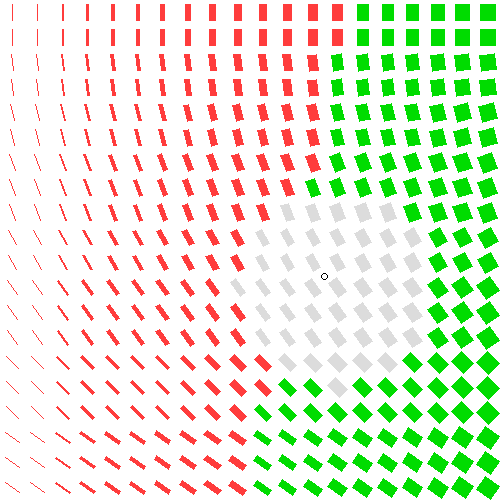

In [2]:

max_displacement_of_line_from_centre = 1/6
test_displacement_from_line = 0.1
test_exclusion_zone = 0.2

def generate_classification_problem():
    # make a random rotation matrix to determine the angle of the partition line
    theta = np.radians(np.random.uniform(0,360))
    c, s = np.cos(theta), np.sin(theta)
    LINE_ROTATION = np.matrix([[c, -s], [s, c]])

    # make a random translation vector to determine the position of the partition line
    # (no further in any dimension than max_displacement_of_line_from_centre from the centre [1/2,1/2])
    LINE_CENTER = np.array([1/2,1/2]) \
                + np.random.uniform(-1,1,2) * max_displacement_of_line_from_centre

    # the test case we will show the user: 
    # start at LINE_CENTER
    # take a vector representing the displacement from line, rotate it orthogonal to the line, and add it
    test_case = np.array(LINE_CENTER + np.dot(np.linalg.inv(LINE_ROTATION),np.array([test_displacement_from_line,0])))[0]

    # which side will be green and which will be red?
    positive_side_red = np.random.random()>0.5

    # (there are more degrees of freedom in the above than necessary, but it doesn't matter)

    # now define a classification method (nb this is bound to the line and test case we have chosen)
    def classify(vec,test_exclusion_zone=test_exclusion_zone):
        '''Classifies a shape defined by a vector of parameters e.g. [thickness,rotation]
        Defines an exclusion_zone around the test case where we return grey instead of a classification.'''
        # check not too close to the test case to classify
        if np.linalg.norm(vec-test_case)<test_exclusion_zone:
            return grey    
        # translate and rotate the point to classify 
        # so that its first coordinate tells us which side of the line it's on
        tran = np.dot(LINE_ROTATION,(vec-LINE_CENTER))
        return {True:red, False:green}[(tran[0,0]>0)==positive_side_red]

    return test_case, classify

def draw_feature_space(classify,test_case):
    '''Draws a visualisation of 2-d feature space spanning (0,0) to (1,1) classified accordingly
    and with test case shown'''
    img = Image.new('RGB', (canvas_size,canvas_size), white)
    draw = ImageDraw.Draw(img)
    for x in range(num_cells):
        for y in range(num_cells):
            shape = np.array([x,y])/num_cells
            colour = classify(shape)
            drawFeature(draw,x,y,shape,colour)
    # draw circle marking position of test_case in feature space
    testx,testy = test_case*canvas_size
    radius = 3
    draw.ellipse([testx-radius,testy-radius,testx+radius,testy+radius],outline="black")
    del draw
    showPIL(img)
    
test_case, classify = generate_classification_problem()
draw_feature_space(classify,test_case)




<p>So, above you can see the feature space, neatly classified, with a test case marked. Finally we need to draw a bunch of pre-classified shapes, plus one mystery one for ourselves to try and classify:</p>


In [3]:

def shuffle(lst):
    '''Shuffles a list'''
    lst = sorted([(np.random.random(),x) for x in lst])
    return [x for _,x in lst]

def draw_randoms(n,classify):
    '''Draws n random shapes in a row, coloured according to classification,
    and ensuring there are equal numbers of each class represented'''
    reds = []
    greens = []
    while len(reds)<n//2 or len(greens)<n//2: # keep generating random shapes until we have enough of each class
        shape = np.random.uniform(0,1,2)
        colour = classify(shape)
        classified_shape = (colour,shape)
        if colour==red:
            reds += [classified_shape]
        if colour==green:
            greens += [classified_shape]
    
    samples = shuffle(reds[0:n//2]+greens[0:n//2]) # take n/2 shapes from each class and shuffle together
    
    img = Image.new('RGB', (int(cell_size*n),int(cell_size)), white)
    draw = ImageDraw.Draw(img)
    for x,(colour,shape) in enumerate(samples):
        drawFeature(draw,x,0,shape,colour)
    del draw
    showPIL(img)

def draw_single(shape):
    '''Draw a single shape on a line of its own'''
    img = Image.new('RGB', (int(cell_size),int(cell_size)), white)
    draw = ImageDraw.Draw(img)
    drawFeature(draw,0,0,shape,(220,220,220))
    del draw
    showPIL(img)

n_shapes = 40
answers = []
for _ in range(3):
    test_case, classify = generate_classification_problem()
    print("Here are %d sample shapes:"%n_shapes)
    draw_randoms(n_shapes,classify)
    print("Given the %d sample shapes on the previous line, what colour should the following shape be?"%n_shapes)
    draw_single(test_case)
    answers += [{red:"red",green:"green"}[classify(test_case,test_exclusion_zone=0)]]
                
print ("(Answers: "+",".join(answers)+")")
                



Here are 40 sample shapes:


Given the 40 sample shapes on the previous line, what colour should the following shape be?


Here are 40 sample shapes:


Given the 40 sample shapes on the previous line, what colour should the following shape be?


Here are 40 sample shapes:


Given the 40 sample shapes on the previous line, what colour should the following shape be?


(Answers: green,green,red)



<p>So I tried these tests on myself, and decided the idea wasn't working. Why? Because I caught myself solving the problems with k-nearest-neighbour classification, in a very definitely classical-feeling sequential way.</p>
<p>Maybe the results would be more interesting if we tried something other than visual shape classification in 2-d feature space? (Most of the code above will easily generalize). Can we test subconscious classification ability - perhaps training with rising or falling sounds, for example, and testing by asking the user to determine the direction of movement of a <a href="https://en.wikipedia.org/wiki/Tritone_paradox">Tritone Paradox</a> (which can be perceived as either rising or falling)?</p>
<p>Anyway it looks like I've so far failed to find any evidence of the brain behaving in a quantum way. Maybe someone else will. Or maybe not.</p>


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd7c04ef-2549-48b7-89c7-868da7720bfe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>